## Efficiencies and working points

This notebook loads cut variables to plot roc curves

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Tagger roc curves

In [5]:
! ls /Users/fmokhtar/Desktop/data_ele_iso.csv

/Users/fmokhtar/Desktop/data_ele_iso.csv


In [14]:
data = {}
data['ele'] = pd.read_csv('/Users/fmokhtar/Desktop/data_ele_iso.csv')

In [15]:
data['ele'].head()

,Unnamed: 0,ele_score,sample,weight
0,1,0.033406,DYJets,-0.122894
1,2,0.666923,DYJets,-0.267017
2,3,0.063267,DYJets,0.257965
3,4,0.649240,DYJets,0.291165
4,5,0.712782,DYJets,0.293626


In [16]:
samples = data['ele']['sample'].unique()
samples

array(['DYJets', 'QCD', 'ttHToNonbb_M125', 'ALL_VH_SIGNALS_COMBINED',
       'GluGluHToWW_Pt-200ToInf_M-125', 'GluGluHToWWToLNuQQ',
       'VBFHToWWToLNuQQ-MH125', 'TTbar', 'SingleTop', 'WJetsLNu'],
      dtype=object)

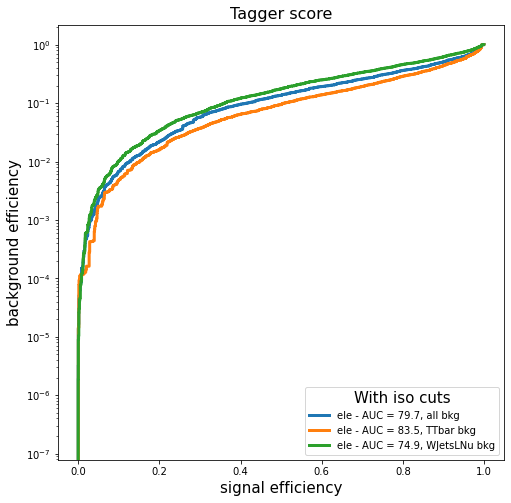

In [29]:
# all bkg

year = '2017'
channels = ['ele']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    # all bkg
    scores_sig = data[ch][f'{ch}_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch][f'{ch}_score'][data[ch]['sample']!='GluGluHToWWToLNuQQ']
    predict = np.concatenate((scores_sig, scores_bkg), axis=None)

    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][data[ch]['sample']!='GluGluHToWWToLNuQQ']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}, all bkg')   
    
    for bkg_sample in ['TTbar', 'WJetsLNu']:
        scores_sig = data[ch][f'{ch}_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
        scores_bkg = data[ch][f'{ch}_score'][data[ch]['sample']==bkg_sample]
        predict = np.concatenate((scores_sig, scores_bkg), axis=None)

        siglabels = np.ones(scores_sig.shape)
        bkglabels = np.zeros(scores_bkg.shape)
        truth = np.concatenate((siglabels, bkglabels), axis=None)

        weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                                 data[ch]['weight'][data[ch]['sample']==bkg_sample]), axis=None)

        fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
        ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}, {bkg_sample} bkg')

ax.set_yscale('log')
ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'background efficiency', fontsize=15)
ax.legend(title='With iso cuts', title_fontsize=15)
ax.set_title(f'Tagger score', fontsize=16);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/tagger_score_roc_all_bkg.pdf')

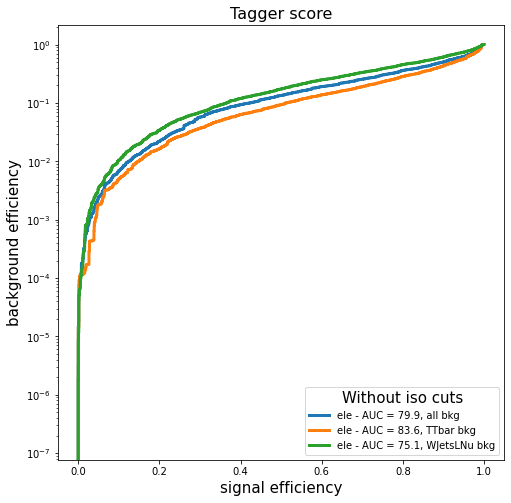

In [30]:
# all bkg
data = {}
data['ele'] = pd.read_csv('/Users/fmokhtar/Desktop/data_ele_noiso.csv')

year = '2017'
channels = ['ele']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    # all bkg
    scores_sig = data[ch][f'{ch}_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch][f'{ch}_score'][data[ch]['sample']!='GluGluHToWWToLNuQQ']
    predict = np.concatenate((scores_sig, scores_bkg), axis=None)

    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][data[ch]['sample']!='GluGluHToWWToLNuQQ']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}, all bkg')   
    
    for bkg_sample in ['TTbar', 'WJetsLNu']:
        scores_sig = data[ch][f'{ch}_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
        scores_bkg = data[ch][f'{ch}_score'][data[ch]['sample']==bkg_sample]
        predict = np.concatenate((scores_sig, scores_bkg), axis=None)

        siglabels = np.ones(scores_sig.shape)
        bkglabels = np.zeros(scores_bkg.shape)
        truth = np.concatenate((siglabels, bkglabels), axis=None)

        weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                                 data[ch]['weight'][data[ch]['sample']==bkg_sample]), axis=None)

        fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
        ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}, {bkg_sample} bkg')

ax.set_yscale('log')
ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'background efficiency', fontsize=15)
ax.legend(title='Without iso cuts', title_fontsize=15)
ax.set_title(f'Tagger score', fontsize=16);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/tagger_score_roc_all_bkg.pdf')

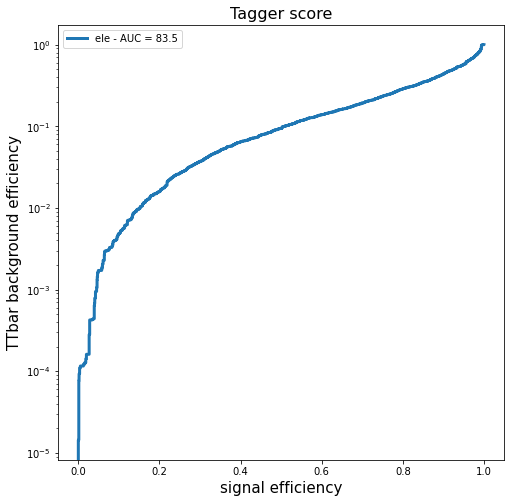

In [24]:
# all bkg

year = '2017'
channels = ['ele']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    scores_sig = data[ch][f'{ch}_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch][f'{ch}_score'][data[ch]['sample']=='TTbar']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)
    
    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][data[ch]['sample']=='TTbar']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}')

ax.set_yscale('log')
ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'TTbar background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Tagger score', fontsize=16);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/tagger_score_roc_all_bkg.pdf')

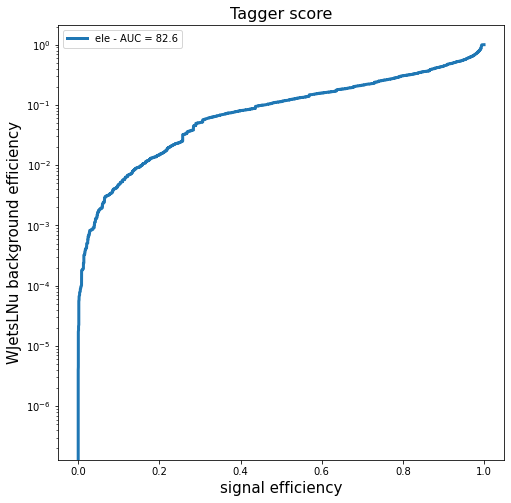

In [22]:
# all bkg

year = '2017'
channels = ['ele']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    scores_sig = data[ch][f'{ch}_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch][f'{ch}_score'][data[ch]['sample']!='WJetsLNu']
    predict = np.concatenate((scores_sig, scores_bkg), axis=None)

    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][data[ch]['sample']!='WJetsLNu']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}')

ax.set_yscale('log')
ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'WJetsLNu background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Tagger score', fontsize=16);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/tagger_score_roc_all_bkg.pdf')

# Phase II

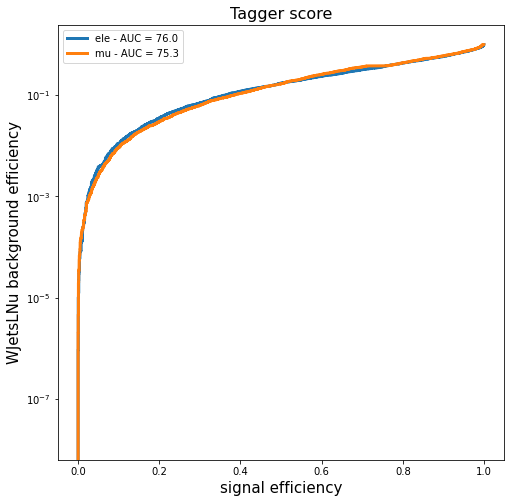

In [63]:
# all bkg

year = '2017'
channels = ['ele', 'mu']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    scores_sig = data[ch]['tagger_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch]['tagger_score'][data[ch]['sample']=='WJetsLNu']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)
    
    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][data[ch]['sample']=='WJetsLNu']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}')

ax.set_yscale('log')
ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'WJetsLNu background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Tagger score', fontsize=16);
plt.savefig(f'/Users/fmokhtar/Desktop/plots/tagger_score_roc_wjets.pdf')

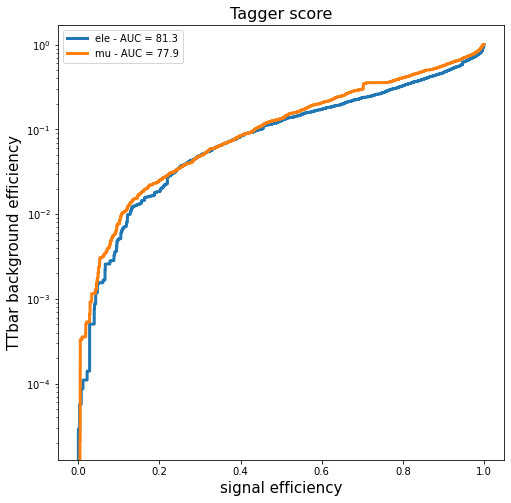

In [64]:
# all bkg

year = '2017'
channels = ['ele', 'mu']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    scores_sig = data[ch]['tagger_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch]['tagger_score'][data[ch]['sample']=='TTbar']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)
    
    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][data[ch]['sample']=='TTbar']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}')

ax.set_yscale('log')
ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'TTbar background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Tagger score', fontsize=16);
plt.savefig(f'/Users/fmokhtar/Desktop/plots/tagger_score_roc_ttbar.pdf')

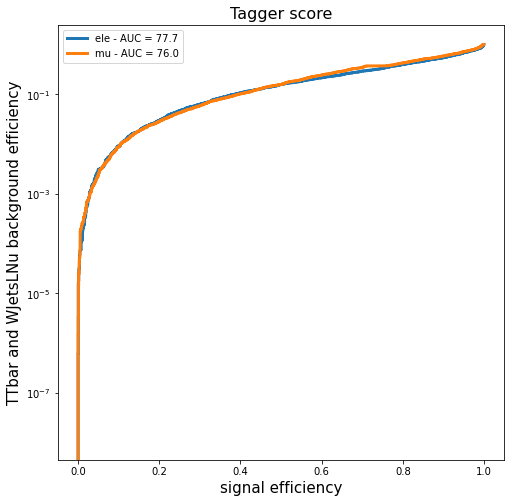

In [65]:
# all bkg

year = '2017'
channels = ['ele', 'mu']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    scores_sig = data[ch]['tagger_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch]['tagger_score'][(data[ch]['sample']=='TTbar') | (data[ch]['sample']=='WJetsLNu')]
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)
    
    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][(data[ch]['sample']=='TTbar') | (data[ch]['sample']=='WJetsLNu')]), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {round(auc(fprs, tprs) * 100,1)}')

ax.set_yscale('log')
ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'TTbar and WJetsLNu background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Tagger score', fontsize=16);
plt.savefig(f'/Users/fmokhtar/Desktop/plots/tagger_score_roc_wjets_ttbar.pdf')

In [ ]:
# all bkg

year = '2017'
channels = ['ele', 'mu']

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8,8))
for ch in channels:

    scores_sig = data[ch]['tagger_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = data[ch]['tagger_score'][data[ch]['sample']=='WJetsLNu']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)
    
    weight = np.concatenate((data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
                             data[ch]['weight'][data[ch]['sample']=='WJetsLNu']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(tprs, fprs, lw=3, label=f'{ch} - AUC = {auc(fprs, tprs) * 100}')

ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'WJetsLNu background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Tagger score', fontsize=16);
# plt.savefig('roc_curves/roc_ele_all.pdf')

In [2]:
sample_mapping = {}
sample_mapping['sig'] = 'GluGluHToWWToLNuQQ'

sample_mapping['dy'] = 'DYJetsToLL_Pt-250To400'
sample_mapping['wjets'] = 'WJetsToLNu_HT-200To400'
sample_mapping['qcd'] = 'QCD_Pt_300to470'

samples = ['sig', 'dy', 'wjets', 'qcd']

channels = ['ele', 'mu']

# get xsecs
xsecs = {'sig': 28.87,
        'dy': 3.43,
        'wjets': 336.5,
        'qcd': 6833.0}

In [4]:
data_iso_ele = pd.read_csv('roc_curves/data_iso_ele.csv')
data_miso_ele = pd.read_csv('roc_curves/data_miso_ele.csv')
data_dphi_ele = pd.read_csv('roc_curves/data_dphi_ele.csv')
data_met_lep_ele = pd.read_csv('roc_curves/data_met_lep_ele.csv')

data_iso_mu = pd.read_csv('roc_curves/data_iso_mu.csv')
data_miso_mu = pd.read_csv('roc_curves/data_miso_mu.csv')
data_dphi_mu = pd.read_csv('roc_curves/data_dphi_mu.csv')
data_met_lep_mu = pd.read_csv('roc_curves/data_met_lep_mu.csv')

In [5]:
data_iso_ele['sample'].unique()

array(['GluGluHToWWToLNuQQ', 'DYJets', 'QCD', 'TTbar', 'SingleTop',
       'WJetsLNu'], dtype=object)

In [6]:
data_miso_ele[data_miso_ele['lep_misolation']>2]

,Unnamed: 0,lep_misolation,sample,weight
743386,10155,2.580118,DYJets,0.002305
761352,33650,3.731149,DYJets,-0.002376
897699,4271,2.009676,WJetsLNu,0.013095
905118,17129,2.008481,WJetsLNu,0.010254
921200,44920,2.250052,WJetsLNu,0.012560
932721,4271,2.009676,WJetsLNu,0.013095
940534,17815,2.008481,WJetsLNu,0.010254
956246,44950,2.250052,WJetsLNu,0.012560
978149,4051,2.004341,WJetsLNu,0.000894
980870,8035,2.061959,WJetsLNu,0.000904


## electron channel

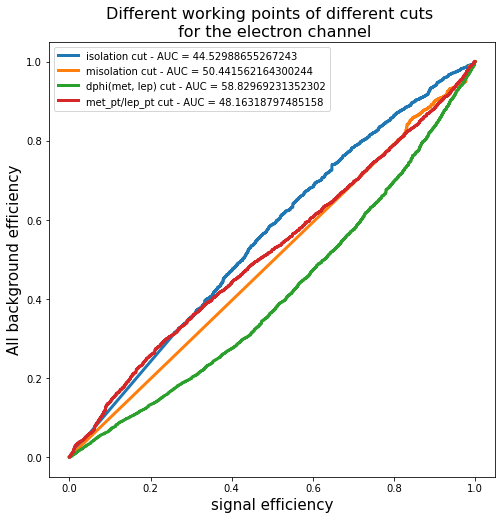

In [58]:
# all bkg

from sklearn.metrics import roc_curve, auc

dic_ele = {'isolation cut': data_iso_ele, 'misolation cut': data_miso_ele, 'dphi(met, lep) cut': data_dphi_ele, 'met_pt/lep_pt cut': data_met_lep_ele}

column = ['lep_isolation', 'lep_misolation', 'met_fj_dphi', '0']


fig, ax = plt.subplots(figsize=(8,8))
for i, (cut, value) in enumerate(dic_ele.items()):

    scores_sig = value[column[i]][value['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = value[column[i]][value['sample']!='GluGluHToWWToLNuQQ']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)
    
    weight = np.concatenate((value['weight'][value['sample']=='GluGluHToWWToLNuQQ'], value['weight'][value['sample']!='GluGluHToWWToLNuQQ']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(1-tprs, 1-fprs, lw=3, label=f'{cut} - AUC = {auc(1-fprs, 1-tprs) * 100}')

ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'All background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Different working points of different cuts \n for the electron channel', fontsize=16)
plt.savefig('roc_curves/roc_ele_all.pdf')

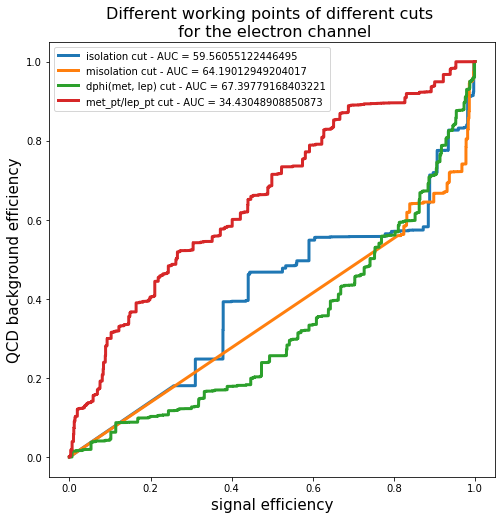

In [57]:
# just QCD

from sklearn.metrics import roc_curve, auc

dic_ele = {'isolation cut': data_iso_ele, 'misolation cut': data_miso_ele, 'dphi(met, lep) cut': data_dphi_ele, 'met_pt/lep_pt cut': data_met_lep_ele}

column = ['lep_isolation', 'lep_misolation', 'met_fj_dphi', '0']


fig, ax = plt.subplots(figsize=(8,8))
for i, (cut, value) in enumerate(dic_ele.items()):

    scores_sig = value[column[i]][value['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = value[column[i]][value['sample']=='QCD']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)
    weight = np.concatenate((value['weight'][value['sample']=='GluGluHToWWToLNuQQ'], value['weight'][value['sample']=='QCD']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(1-tprs, 1-fprs, lw=3, label=f'{cut} - AUC = {auc(1-fprs, 1-tprs) * 100}')

ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'QCD background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Different working points of different cuts \n for the electron channel', fontsize=16)
plt.savefig('roc_curves/roc_ele_qcd.pdf')

## muon channel

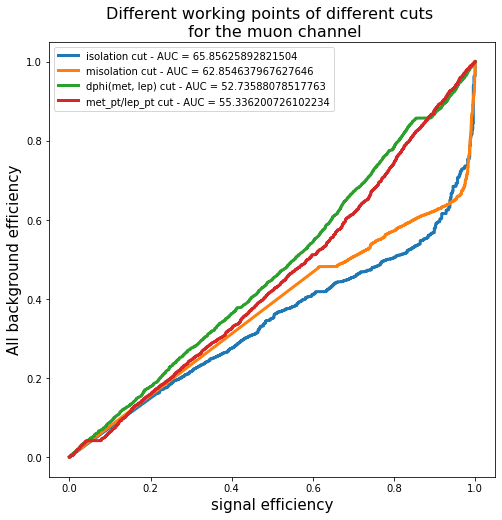

In [56]:
# all bkg

from sklearn.metrics import roc_curve, auc

dic_mu = {'isolation cut': data_iso_mu, 'misolation cut': data_miso_mu, 'dphi(met, lep) cut': data_dphi_mu, 'met_pt/lep_pt cut': data_met_lep_mu}

column = ['lep_isolation', 'lep_misolation', 'met_fj_dphi', '0']

fig, ax = plt.subplots(figsize=(8,8))
for i, (cut, value) in enumerate(dic_mu.items()):

    scores_sig = value[column[i]][value['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = value[column[i]][value['sample']!='GluGluHToWWToLNuQQ']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)

    weight = np.concatenate((value['weight'][value['sample']=='GluGluHToWWToLNuQQ'], value['weight'][value['sample']!='GluGluHToWWToLNuQQ']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=np.absolute(weight))
    ax.plot(1-tprs, 1-fprs, lw=3, label=f'{cut} - AUC = {auc(1-fprs, 1-tprs) * 100}')

ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'All background efficiency', fontsize=15)
ax.legend()
ax.set_title(f'Different working points of different cuts \n for the muon channel', fontsize=16)
plt.savefig('roc_curves/roc_mu_all.pdf')

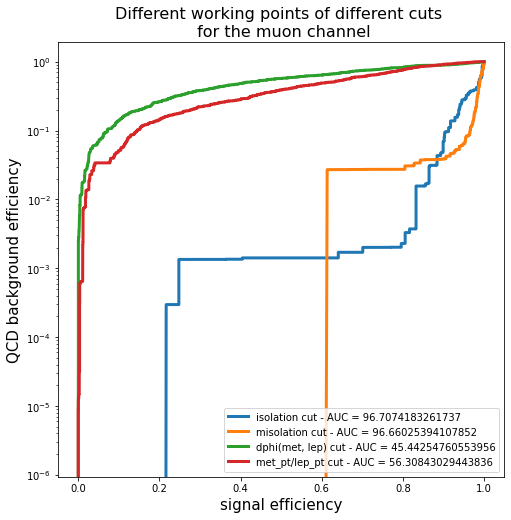

In [55]:
# just QCD

from sklearn.metrics import roc_curve, auc

dic_mu = {'isolation cut': data_iso_mu, 'misolation cut': data_miso_mu, 'dphi(met, lep) cut': data_dphi_mu, 'met_pt/lep_pt cut': data_met_lep_mu}

column = ['lep_isolation', 'lep_misolation', 'met_fj_dphi', '0']

fig, ax = plt.subplots(figsize=(8,8))
for i, (cut, value) in enumerate(dic_mu.items()):

    scores_sig = value[column[i]][value['sample']=='GluGluHToWWToLNuQQ']
    scores_bkg = value[column[i]][value['sample']=='QCD']
    
    siglabels = np.ones(scores_sig.shape)
    bkglabels = np.zeros(scores_bkg.shape)
    truth = np.concatenate((siglabels, bkglabels), axis=None)

    predict = np.concatenate((scores_sig, scores_bkg), axis=None)

    weight = np.concatenate((value['weight'][value['sample']=='GluGluHToWWToLNuQQ'], value['weight'][value['sample']=='QCD']), axis=None)

    fprs, tprs, threshold = roc_curve(truth, predict, sample_weight=weight)
    ax.plot(1-tprs, 1-fprs, lw=3, label=f'{cut} - AUC = {auc(1-fprs, 1-tprs) * 100}')

ax.set_xlabel(r'signal efficiency', fontsize=15)
ax.set_ylabel(r'QCD background efficiency', fontsize=15)
ax.legend()
ax.set_yscale('log')
ax.set_title(f'Different working points of different cuts \n for the muon channel', fontsize=16)
plt.savefig('roc_curves/roc_mu_qcd.pdf')